# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            #("Landshut" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,188.0,185.0,172.0,165.0,180.0,185.0,170.0,157.0,158.0,121.0,157.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
startup_counter,138.0,105.0,100.0,101.0,100.0,97.0,93.0,85.0,93.0,82.0,90.0
shutdown_counter,138.0,107.0,100.0,101.0,101.0,99.0,93.0,85.0,93.0,84.0,95.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [4]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1486144 - Forsa Hartmoor M01', …

In [5]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M01,M01,AL87,624,H12,24,4495.0,24.5,1486144,159396,194.0,2022-01-10,63,131.0,0.141


In [6]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_day=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'])
fsm = msgFSM(e)
fsm.run1() # run Finite State Machine
fsm.run2() # Ergebnisse verfeinern und ergänzen

# Struktur zur Aufnahme mehrerer motoren
fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

FSM: 100%|██████████████████████| 15973/15973 [00:01<00:00, 13800.26 messages/s]


In [7]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)

,From,To,Days
Interval,27.10.2021,25.02.2022,120


,Starts,successful,%
???,0,0,0
OFF,11,1,9
MANUAL,90,29,32
AUTO,105,81,77
ALL,206,111,53


In [8]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))

In [9]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))

In [11]:
rdf = res['result']
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['MANUAL', 'AUTO'] [True]


In [12]:
# special filters can be added like ... 
#rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

#rda = rda[((rda['count_warnings'] > 0) | (rda['count_alarms'] > 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filter_content + ['count_alarms', 'count_warnings']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,count_alarms,count_warnings
0,True,MANUAL,161.32,3.93,18.89,17.97,38.33,138.89,379.33,0 days 00:00:27,0,0
1,True,MANUAL,99.66,3.94,19.36,11.31,47.26,138.89,320.42,0 days 00:00:50,0,1
2,True,MANUAL,136.52,3.84,18.97,5.64,46.46,138.89,350.32,0 days 00:02:32,0,0
3,True,MANUAL,96.96,3.73,22.30,13.74,47.53,138.89,323.15,0 days 00:03:47,0,0
4,True,MANUAL,116.34,3.94,17.46,5.14,51.46,138.89,333.23,0 days 00:01:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
105,True,AUTO,99.79,3.83,24.41,4.84,59.45,85.07,277.39,0 days 05:13:30,0,0
106,True,AUTO,99.34,4.15,23.30,4.64,64.47,81.53,277.44,0 days 03:13:30,0,0
107,True,AUTO,103.73,3.84,23.71,4.74,48.64,92.35,277.00,0 days 01:43:30,0,0
108,True,AUTO,104.40,3.83,25.32,4.84,1.71,135.81,275.92,0 days 01:33:33,0,0


In [14]:
startversuch = rda.iloc[3];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())

cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von: {von_dt} = {von} bis: {bis_dt} = {bis}")
data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1)

von: 2021-11-23 08:07:35.284000 = 1637654855 bis: 2021-11-23 08:16:45.478000128 = 1637655405


Load Data: 50000 datarows [00:00, 264875.53 datarows/s]                         


In [18]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(6,4))

In [19]:
def local_detect_edge(data, name, kind='left'):
    fac = {'left': -1.0, 'right': 1.0}
    ldata = data[['datetime',name]]
    x0 = ldata.iloc[0]['datetime'];
    x1 = ldata.iloc[-1]['datetime'];
    edge0 = data.loc[data[name].idxmax()]
    
    try:
        if kind == 'left':
            xfac = (x1 - x0) / (edge0.datetime - x0)
        elif kind == 'right':
            xfac = (x1 - x0) / (x1 - edge0.datetime)
        else:
            raise ValueError('detect_edge: unknown kind parameter value.')
    except ZeroDivisionError:
        xfac = 0.0
    xfac = min(xfac, 5.0)
    #print(f"###### | xfac: {xfac:5.2f} | kind: {kind:>5} | name: {name}")
    lmax = ldata.loc[:,name].max() * xfac * 0.90

    data[name+'_'+kind] = data[name]+(data['datetime'] - x0)*(fac[kind] * lmax)/(x1-x0) + lmax* (1-fac[kind])/2
    
    Point = namedtuple('edge',["loc", "val"])
    edge = data.loc[data[name+'_'+kind].idxmax()]
    return  Point(edge.datetime, ldata.at[edge.name,name])

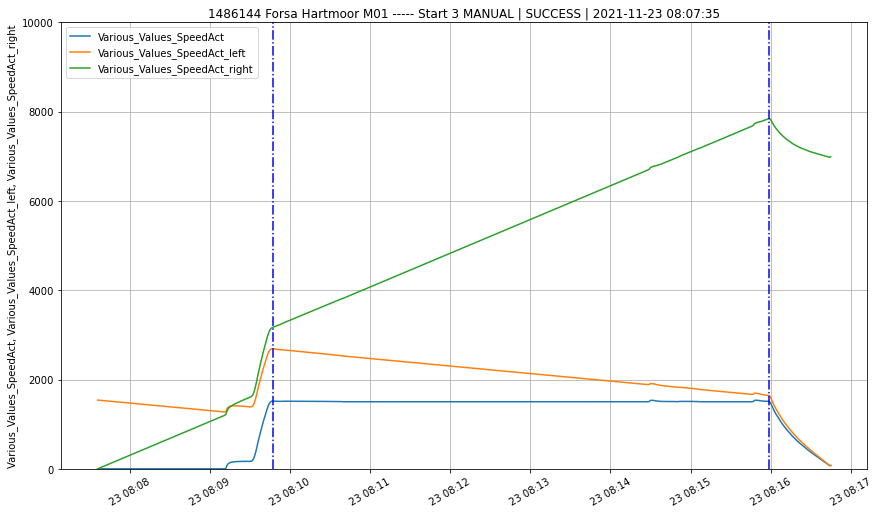

In [20]:
dset = [
    {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,10000)}
]
pl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
pr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

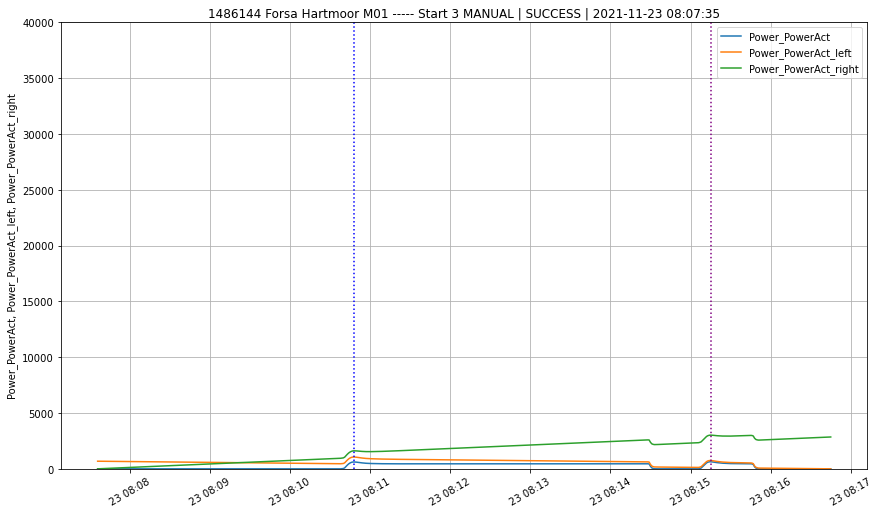

In [21]:
dset = [
    {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], 'ylim':(0,40000)}
]
pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle=":")
dmyplant2.add_lines(pr.loc, [], ax, color='purple', linestyle=":")

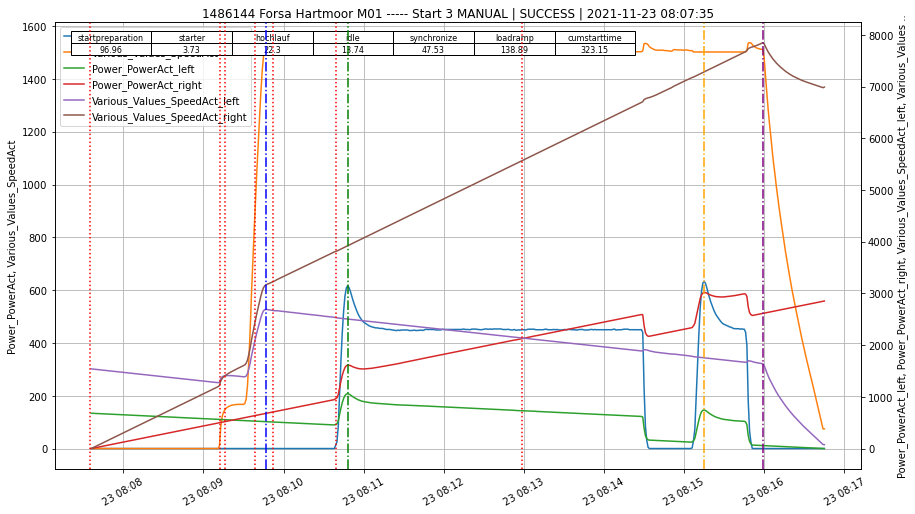

In [23]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,40000)},
    {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], '_ylim':(0,40000)}
    ]

pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)

sv_lines = [v for v in startversuch[fsm.vertical_lines_times] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")
dmyplant2.add_lines(sl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(sr.loc, [], ax, color='purple', linestyle="-.")
dmyplant2.add_lines(pl.loc, [], ax, color='green', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='orange', linestyle="-.")

summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
dmyplant2.add_table(summary, ax, loc='upper left')

plt.show()

Load Data: 50000 datarows [00:02, 22917.44 datarows/s]                          


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,161.322999,3.928999,18.891,17.97,38.329999,138.888,-,-,379.330997
RUN2,161.32,3.93,18.89,17.97,38.33,7.68,624.58,1.81,248.12


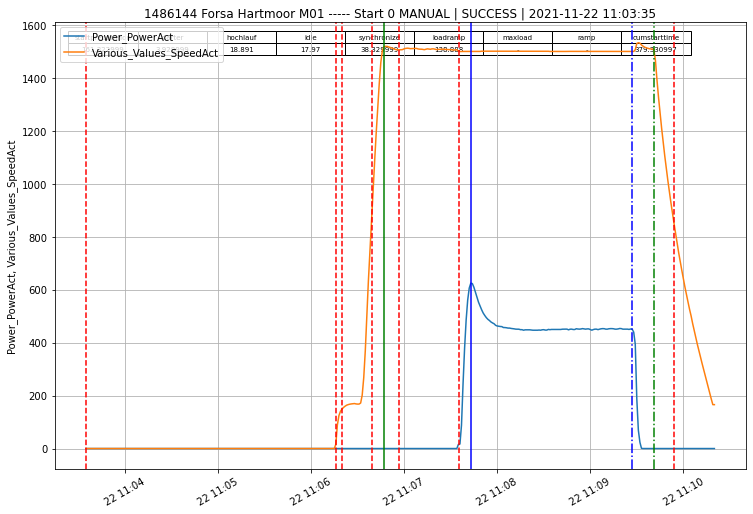

Load Data: 50000 datarows [00:01, 28644.17 datarows/s]                          


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,99.657,3.938999,19.363,11.311,47.257999,138.888,-,-,320.415998
RUN2,99.66,3.94,19.36,11.31,47.26,8.12,633.21,1.73,189.65


loadramp         000000 700 1637590908980 22.11.2021 14:21:48  9304 Deviation in switch-on time for generator switch


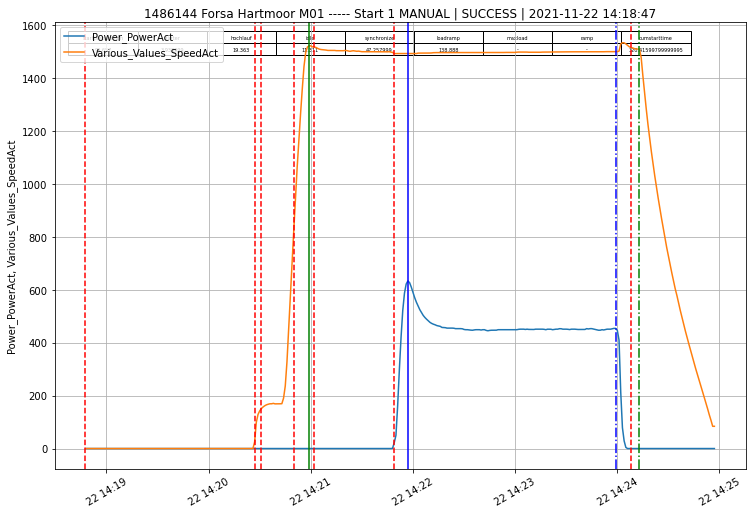

Load Data: 50000 datarows [00:00, 272565.90 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,136.519,3.836999,18.972,5.644,46.460999,138.888,-,-,350.320998
RUN2,136.52,3.84,18.97,5.64,46.46,7.97,634.2,1.77,219.4


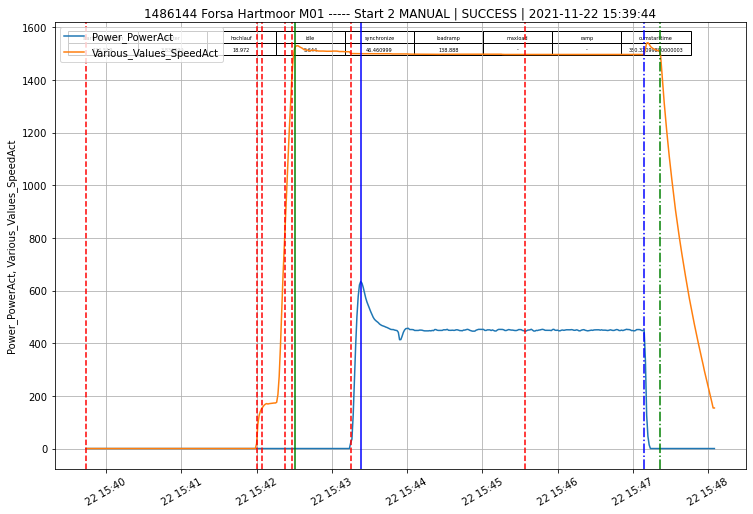

Load Data: 50000 datarows [00:00, 274806.75 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,96.963,3.728,22.300999,13.738,47.530999,138.888,-,-,323.148998
RUN2,96.96,3.73,22.3,13.74,47.53,8.46,615.98,1.62,192.72


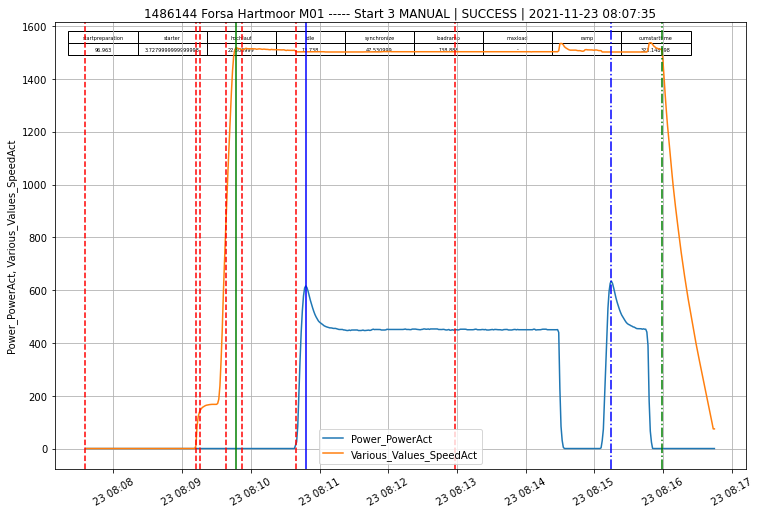

Load Data: 50000 datarows [00:00, 288229.49 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,116.342,3.935,17.464999,5.144,51.458999,138.888,-,-,333.232998
RUN2,116.34,3.94,17.46,5.14,51.46,7.95,629.47,1.76,202.3


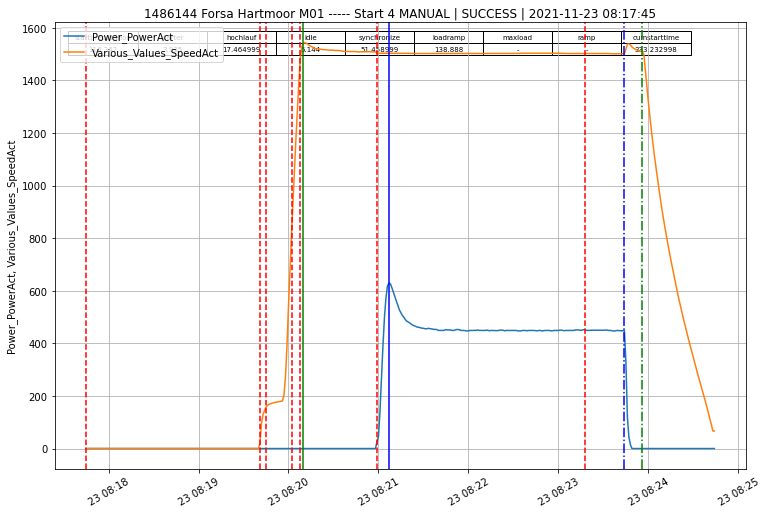

Load Data: 50000 datarows [00:00, 280736.47 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,96.749,3.528,17.961999,5.346,36.412999,138.888,-,-,298.885998
RUN2,96.75,3.53,17.96,5.35,36.41,60.79,1100.16,0.4,220.79


targetoperation  000000 800 1637657237620 23.11.2021 08:47:17  1132 Differential protection
loadramp         000000 700 1637656596861 23.11.2021 08:36:36  3527 Heating water return temperature before engine high
targetoperation  000001 700 1637656809121 23.11.2021 08:40:09  3527 Heating water return temperature before engine high
targetoperation  000002 700 1637657090283 23.11.2021 08:44:50  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000003 700 1637657142763 23.11.2021 08:45:42  3562 Charge temperature minimum


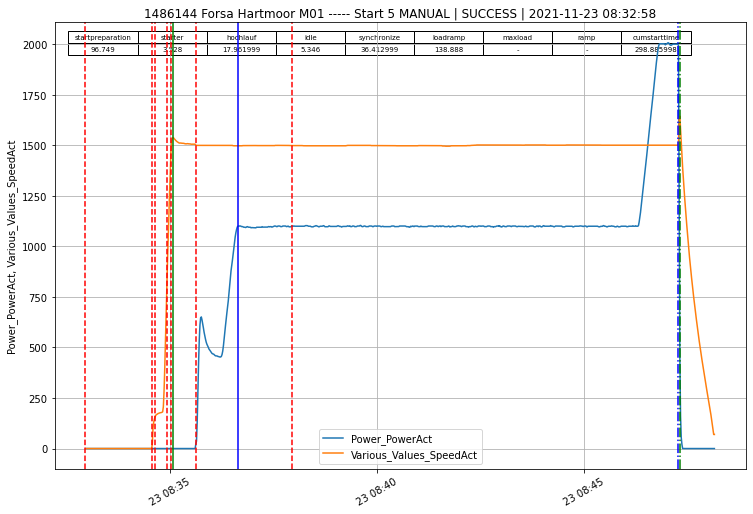

Load Data: 50000 datarows [00:00, 287834.29 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,103.033,4.128,18.265999,5.644999,51.045,138.888,-,-,321.004998
RUN2,103.03,4.13,18.27,5.64,51.04,7357.4,4494.0,0.01,7539.52


loadramp         000000 700 1637660411481 23.11.2021 09:40:11  3527 Heating water return temperature before engine high
targetoperation  000001 700 1637661630009 23.11.2021 10:00:30  3411 Charge temperature maximum
targetoperation  000002 700 1637661732381 23.11.2021 10:02:12  3562 Charge temperature minimum
targetoperation  000003 700 1637661732482 23.11.2021 10:02:12  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000004 700 1637663544819 23.11.2021 10:32:24  3527 Heating water return temperature before engine high
targetoperation  000005 700 1637667169281 23.11.2021 11:32:49  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000006 700 1637667403194 23.11.2021 11:36:43  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000007 700 1637667403901 23.11.2021 11:36:43  3562 Charge temperature minimum
targetoperation  000008 700 1637667823553 23.11.2021 11:43:43  3411 Charge temperature m

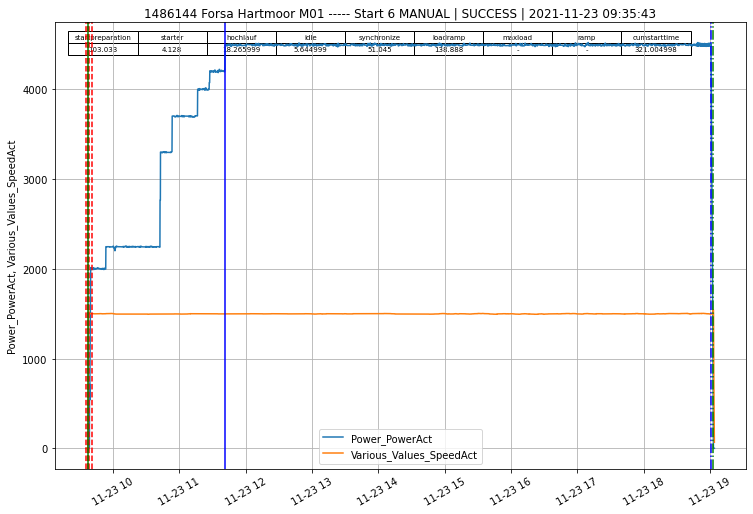

Load Data: 50000 datarows [00:00, 279058.43 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,170.281999,3.739,23.212999,5.953,51.785999,138.888,-,-,393.860997
RUN2,170.28,3.74,23.21,5.95,51.79,130.35,4508.0,0.77,385.33


targetoperation  000000 700 1637753030422 24.11.2021 11:23:50  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637753061224 24.11.2021 11:24:21  3562 Charge temperature minimum


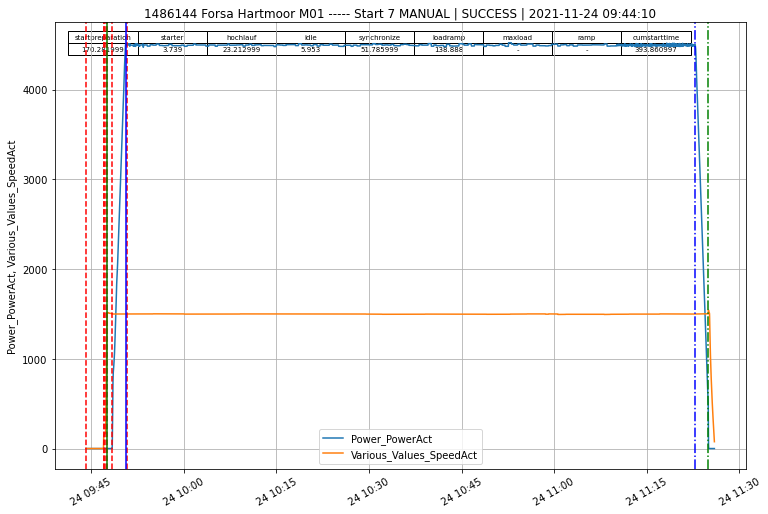

Load Data: 50000 datarows [00:00, 279532.68 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,100.786999,3.735,20.77,5.851,40.430999,125.961,-,-,297.534998
RUN2,100.79,3.74,20.77,5.85,40.43,127.09,4487.16,0.79,298.66


targetoperation  000000 800 1637761218546 24.11.2021 13:40:18  1028 Gas pressure low in gas train 1
targetoperation  000000 700 1637761169251 24.11.2021 13:39:29  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637761169554 24.11.2021 13:39:29  3562 Charge temperature minimum


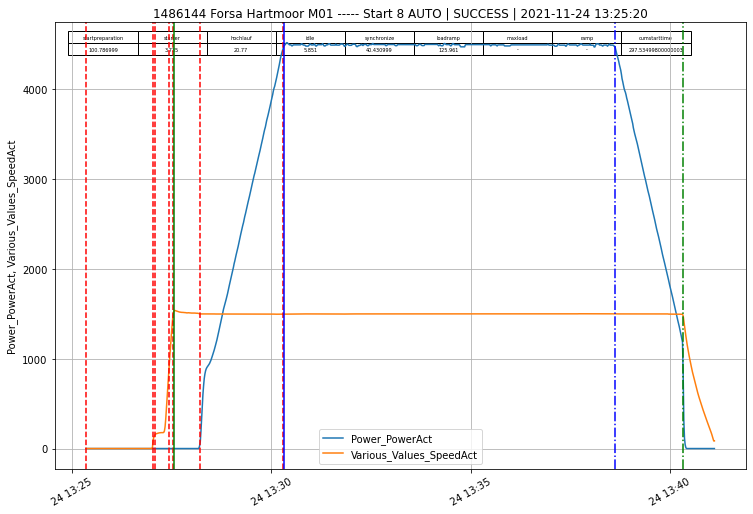

Load Data: 50000 datarows [00:00, 279696.72 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,60.639,3.936,19.559,5.346999,45.31,138.888,-,-,273.678999
RUN2,60.64,3.94,19.56,5.35,45.31,55.08,2127.77,0.86,189.87


loadramp         000000 800 1637766670956 24.11.2021 15:11:10  3339 Knocking failure


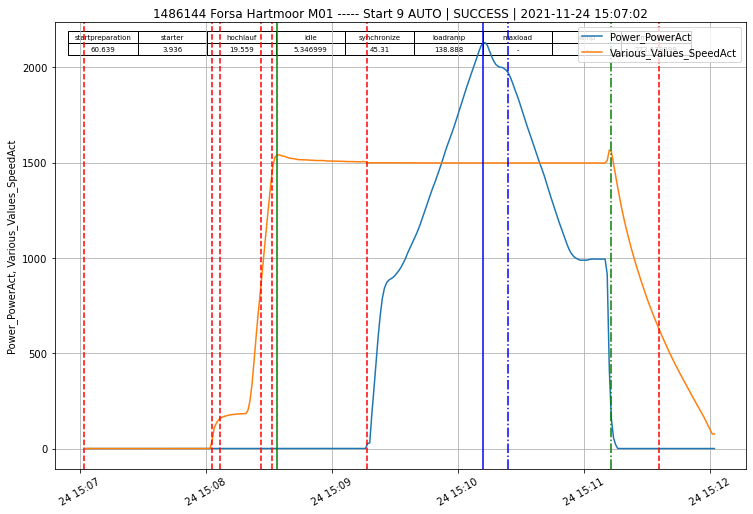

Load Data: 50000 datarows [00:00, 298356.24 datarows/s]                         


,startpreparation,starter,hochlauf,idle,synchronize,loadramp,maxload,ramp,cumstarttime
FSM,101.383,3.556999,19.099,5.764,41.877999,138.888,-,-,310.568998
RUN2,101.38,3.56,19.1,5.76,41.88,1444.22,4506.0,0.07,1615.9


targetoperation  000000 700 1637768496481 24.11.2021 15:41:36  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637768884319 24.11.2021 15:48:04  3562 Charge temperature minimum
targetoperation  000002 700 1637768996086 24.11.2021 15:49:56  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000003 700 1637770286048 24.11.2021 16:11:26  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000004 700 1637770289480 24.11.2021 16:11:29  3562 Charge temperature minimum
targetoperation  000005 700 1637777164708 24.11.2021 18:06:04  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000006 700 1637777170971 24.11.2021 18:06:10  3562 Charge temperature minimum


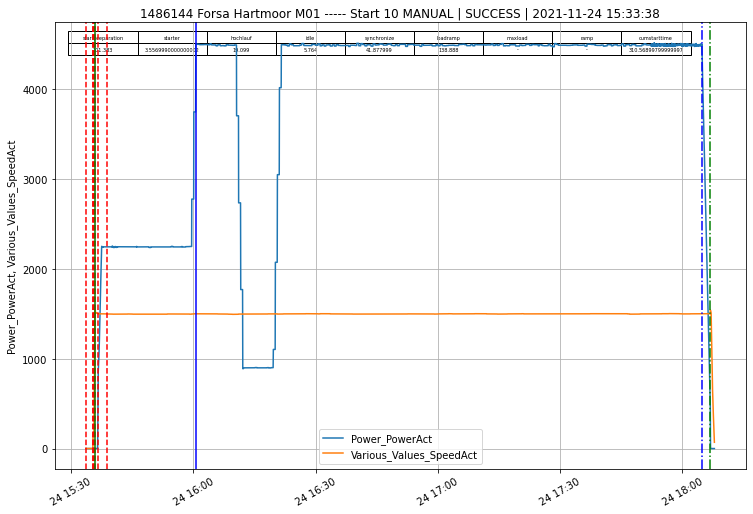

In [24]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,10000)}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 10:
                break
        data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1)

        pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
        pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
        sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
        sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')

        ftitle = f"{fsm._e} ----- Start {ii} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
        #ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
        fig, ax, axes = dmyplant2.chart(data, dset, figsize=(12,8), title=ftitle)

        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
        sv_lines = [v for v in startversuch[fsm.vertical_lines_times]]

        start = startversuch['starttime'];
        
        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
        lines=list(np.cumsum(nsv_lines))
        dmyplant2.add_lines(start, lines, ax, color='red', linestyle="--")

        dmyplant2.add_lines(sl.loc, [], ax, color='green', linestyle="-")
        dmyplant2.add_lines(sr.loc, [], ax, color='green', linestyle="-.")
        dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-")
        dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

        svdf = pd.DataFrame(sv_lines, index=fsm.vertical_lines_times, columns=['FSM']).fillna(0)
        svdf['RUN2'] = svdf['FSM']
        #if svdf.at['hochlauf','FSM'] > 0.0:
        #        svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
        #        svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
        if svdf.at['loadramp','FSM'] > 0.0:
                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
        svdf = pd.concat([
                svdf, 
                pd.DataFrame.from_dict(
                        {       'maxload':['-',pl.val],
                                'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                        }, 
                        columns=['FSM','RUN2'],
                        orient='index')]
                )


        #summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
        summary = pd.DataFrame(svdf['FSM']).round(1).T
        dmyplant2.add_table(summary, ax, loc='upper left')
        #display(HTML(summary.to_html(escape=False)))
        display(HTML(svdf.round(2).T.to_html(escape=False)))


        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")
        
        #fsm.plot_cycle(startversuch, max_length=600, ylim=(0,2500), cycletime=1, style='.-', figsize=(10,6), 
        #    title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
        plt.show();

In [ ]:
rda.describe().round(1).T

In [ ]:
svdf

In [ ]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rda['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2)

In [ ]:
longer_than_300s.describe().round(2).T

In [ ]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rda['loadramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()